In [1]:
import statistics
from collections import defaultdict
from tqdm.notebook import tqdm

import pyro
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(7)
pyro.set_rng_seed(0)
np.random.seed(19680801)

from pyro.infer import SVI, Trace_ELBO, Importance, EmpiricalMarginal
import torch.distributions.constraints as constraints
from pyro.optim import Adam

# Constants
MAX_ABUNDANCE = 100

In [2]:
# load data
data_path = "../bel2scm/Tests/Data/observational_igf.csv"

data = pd.read_csv(data_path)
num_samples = data.shape[0]

single_interaction_data = data[["a(p(AKT))","a(p(Ras))","a(p(Raf))"]]
# single_interaction_data.to_csv("../bel2scm/Tests/Data/single_interaction_data.csv")

parent = single_interaction_data[["a(p(AKT))", "a(p(Ras))"]].to_numpy()
target = single_interaction_data["a(p(Raf))"].to_numpy()

In [3]:
parent.shape

(5000, 2)

In [4]:
np.ones((len(parent), 1)).shape

(5000, 1)

In [5]:

# # Log transformation
def transform_target_to_log(target):
    return np.log(target / (MAX_ABUNDANCE - target))



target_transformed_to_log = transform_target_to_log(target)


Features = np.hstack([parent, np.ones((len(parent), 1))])


In [10]:
# Linear Regression - get slope and intercept
betas = np.linalg.lstsq(Features, target_transformed_to_log, rcond=None)[0]
print(betas)

In [20]:
# sigmoid function
def sigmoid(x, betas):
    return MAX_ABUNDANCE / (1 + np.exp(-np.dot(x, betas)))


predicted_target = sigmoid(Features, betas)
print(predicted_target[:6])

print(target[:6])

[37.1359969  37.98403802 36.88391986 34.59995603 34.21682512 35.84805636]
[39 36 42 29 36 35]


In [21]:
# Report mean squared error

mse = np.square(np.subtract(target, predicted_target)).mean()

print("Mean squared error on train:", mse)

Mean squared error on train: 24.46474722000163


### Regression line in log space

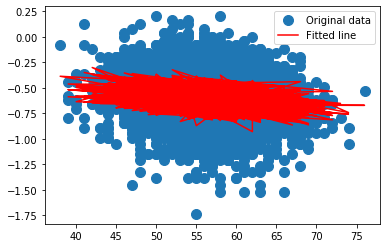

In [22]:
_ = plt.plot(parent[:,0], target_transformed_to_log, 'o', label='Original data', markersize=10)
_ = plt.plot(parent[:,0], np.dot(Features, betas), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

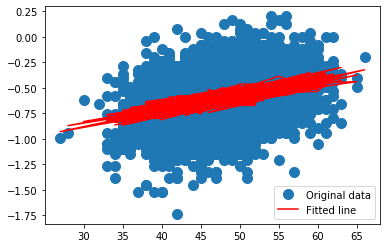

In [23]:
_ = plt.plot(parent[:,1], target_transformed_to_log, 'o', label='Original data', markersize=10)

_ = plt.plot(parent[:,1], np.dot(Features, betas), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### Regression line in actual space 

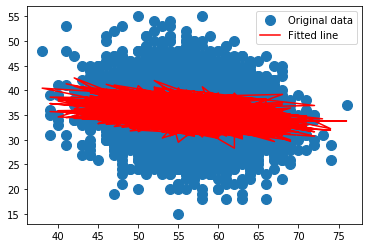

In [25]:
_ = plt.plot(parent[:,0], target, 'o', label='Original data', markersize=10)
_ = plt.plot(parent[:,0], predicted_target, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

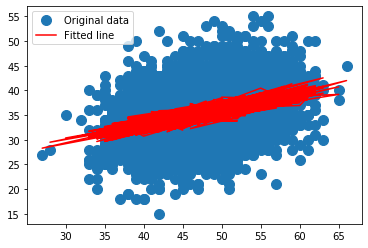

In [26]:
_ = plt.plot(parent[:,1], target, 'o', label='Original data', markersize=10)
_ = plt.plot(parent[:,1], predicted_target, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### get residual and parent statistics

In [29]:
residual_std = np.abs(np.subtract(target, predicted_target)).std()
residual_mean = np.abs(np.subtract(target, predicted_target)).mean()
print(residual_mean)
print(residual_std)

akt_mean = parent[:,0].mean()
akt_std = parent[:,0].std()

ras_mean = parent[:,1].mean()
ras_std = parent[:,1].std()

3.940202193625731
2.9899086764228446


### Define Pyro model

In [53]:

# # sigmoid with noise
# def sigmoid_with_residual_noise(x, w, b, noise):
#     return MAX_ABUNDANCE / (1 + np.exp(-1*(w*x + b + noise)))

# pyro model
def model(n_raf):
    noise = pyro.sample("n_Raf", n_raf)
    akt = pyro.sample("AKT", pyro.distributions.Normal(akt_mean, akt_std))
    ras = pyro.sample("Ras", pyro.distributions.Normal(ras_mean, ras_std))

    parent_array = np.array([akt.detach().numpy(), ras.detach().numpy(), 1.]).reshape(-1,1).T
    raf_mean = sigmoid(parent_array, betas)+ noise.detach().numpy()
    raf = pyro.sample("Raf", pyro.distributions.Normal(torch.tensor(raf_mean), torch.tensor(1.0)))
    return akt, ras, raf

In [31]:
n_raf = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(residual_std))
samples = torch.tensor([model(n_raf) for _ in range(3000)])

In [32]:
samples[:20]

tensor([[54.6233, 35.9040, 37.0744],
        [48.9140, 49.7683, 34.6637],
        [54.0555, 44.3991, 32.6292],
        [61.8249, 41.8511, 30.2597],
        [58.0667, 42.8132, 30.3244],
        [63.6635, 52.6487, 37.6930],
        [62.6680, 40.6739, 32.0041],
        [52.4275, 50.3873, 35.3704],
        [58.9432, 35.6893, 32.0704],
        [53.5523, 49.0704, 32.1581],
        [57.6276, 47.5621, 34.0414],
        [54.7620, 48.6197, 32.3586],
        [55.9562, 47.9394, 40.8261],
        [70.3795, 48.5438, 35.9015],
        [52.7245, 54.7073, 33.6423],
        [55.4498, 57.7662, 40.9588],
        [54.4035, 39.1729, 32.7852],
        [62.1891, 49.9303, 37.5974],
        [60.7220, 51.7260, 32.0110],
        [58.9907, 44.4949, 34.6042]], dtype=torch.float64)

### Generated samples Vs. Original Data

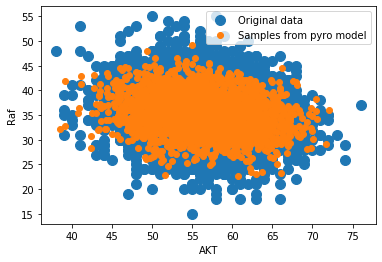

In [33]:
_ = plt.plot(parent[:,0], target, 'o', label='Original data', markersize=10)
_ = plt.plot(samples[:,0], samples[:,2], 'o', label='Samples from pyro model')
_ = plt.legend()
_= plt.xlabel("AKT")
_= plt.ylabel("Raf")
plt.show()

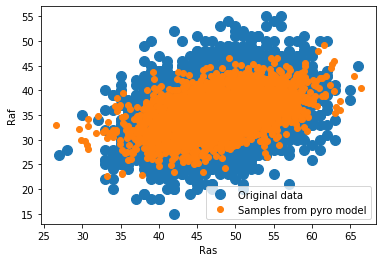

In [34]:
_ = plt.plot(parent[:,1], target, 'o', label='Original data', markersize=10)
_ = plt.plot(samples[:,1], samples[:,2], 'o', label='Samples from pyro model')
_ = plt.legend()
_ = plt.xlabel("Ras")
_ = plt.ylabel("Raf")
plt.show()

## Counterfactual Inference

In [43]:

def infer_using_svi(conditioned_model, n_raf):

    def guide(n_raf):
        mu_constraints = constraints.interval(0., 5.)
        sigma_constraints = constraints.interval(.1, 7.)
        mu_guide = pyro.param("mu_n_Raf", torch.tensor(0.0), constraint=mu_constraints)
        sigma_guide = pyro.param("sigma_n_Raf", torch.tensor(residual_std),
                                     constraint=sigma_constraints)
        pyro.sample("n_Raf", pyro.distributions.Normal(mu_guide, sigma_guide))

    pyro.clear_param_store()

    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=Adam({"lr": 0.05, "betas": (0.95, 0.999)}),
        loss=Trace_ELBO(retain_graph=True)
    )
    losses = []
    num_steps = 1000
    samples = defaultdict(list)
    for t in tqdm(range(num_steps)):
        loss = svi.step(n_raf)
        #print(t, loss)
        losses.append(loss)
        mu = 'mu_n_Raf'
        sigma = 'sigma_n_Raf'
        samples[mu].append(pyro.param(mu).item())
        samples[sigma].append(pyro.param(sigma).item())
    means = {k: statistics.mean(v) for k, v in samples.items()}

    updated_noise = {}
    updated_noise = pyro.distributions.Normal(means["mu_n_Raf"], means["sigma_n_Raf"])

    return updated_noise, losses

In [44]:
def counterfactual_inference(parent_name, intervened_parent):
    n_raf = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_akt, observed_ras, observed_raf = model(n_raf)

    print("Observed AKT:", observed_akt,"Observed Ras:", observed_ras, "Observed Raf:", observed_raf)
    print("What would happen to Raf if {} was {} ?".format(parent_name, intervened_parent))
    conditioned_model = pyro.condition(model, data={"AKT": observed_akt, "Ras": observed_ras, 
                                                    "Raf": observed_raf})
    
    updated_n_raf= infer_using_svi(conditioned_model, n_raf)
    #update noise for everything
    intervention_model = pyro.do(model, data={parent_name:torch.tensor(intervened_parent)})
    return intervention_model, updated_n_raf[0]

In [37]:
def counterfactual_inference_ras(intervened_ras):
    n_raf = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_akt, observed_ras, observed_raf = model(n_raf)

    print("Observed AKT:", observed_akt,"Observed Ras:", observed_ras, "Observed Raf:", observed_raf)
    print("What would happen to Raf if Ras was", intervened_ras, "?")
    conditioned_model = pyro.condition(model, data={"AKT": observed_akt,"Ras": observed_ras, "Raf": observed_raf})
    updated_n_raf = infer_using_svi(conditioned_model, n_raf)

    intervention_model = pyro.do(model, data={"Ras":torch.tensor(intervened_ras)})
    return intervention_model, updated_n_raf[0]

In [54]:
intervened_model_1, noise_1 = counterfactual_inference("AKT", 40.)
intervened_model_2, noise_2 = counterfactual_inference("AKT", 70.)
intervened_model_3, noise_3 = counterfactual_inference_ras(40.)
intervened_model_4, noise_4 = counterfactual_inference_ras(70.)

counterfactual_raf_1 = torch.tensor([intervened_model_1(noise_1)[2] for _ in range(1000)])
counterfactual_raf_2 = torch.tensor([intervened_model_2(noise_2)[2] for _ in range(1000)])


counterfactual_raf_3 = torch.tensor([intervened_model_3(noise_3)[2] for _ in range(1000)])
counterfactual_raf_4 = torch.tensor([intervened_model_4(noise_4)[2] for _ in range(1000)])

Observed AKT: tensor(59.0640) Observed Ras: tensor(50.5961) Observed Raf: tensor([36.0961], dtype=torch.float64)
What would happen to Raf if AKT was 40.0 ?



Observed AKT: tensor(59.8802) Observed Ras: tensor(48.9156) Observed Raf: tensor([31.8210], dtype=torch.float64)
What would happen to Raf if AKT was 70.0 ?



Observed AKT: tensor(59.4075) Observed Ras: tensor(48.0340) Observed Raf: tensor([29.5313], dtype=torch.float64)
What would happen to Raf if Ras was 40.0 ?



Observed AKT: tensor(61.5759) Observed Ras: tensor(48.4160) Observed Raf: tensor([33.8952], dtype=torch.float64)
What would happen to Raf if Ras was 70.0 ?


In [55]:
noise_1, noise_2

(Normal(loc: 5.877471754111438e-38, scale: 3.0030407905578613),
 Normal(loc: 5.877471754111438e-38, scale: 2.976428508758545))

In [56]:
noise_3, noise_4

(Normal(loc: 5.877471754111438e-38, scale: 3.0503764152526855),
 Normal(loc: 5.877471754111438e-38, scale: 3.0411033630371094))

In [57]:
print(counterfactual_raf_1[:10])
print(counterfactual_raf_2[:10])
print(counterfactual_raf_3[:10])
print(counterfactual_raf_4[:10])

tensor([36.0364, 35.1635, 38.9538, 42.6362, 42.1409, 39.2864, 40.0686, 39.4217,
        43.9810, 40.7489], dtype=torch.float64)
tensor([32.7425, 32.8350, 34.2988, 41.8994, 24.0241, 33.3190, 36.5201, 33.0246,
        34.4414, 36.7887], dtype=torch.float64)
tensor([40.2525, 28.8604, 30.5517, 35.2874, 36.6940, 31.4526, 33.0373, 28.8685,
        32.1400, 32.5425], dtype=torch.float64)
tensor([48.1010, 46.1502, 42.1257, 45.0455, 48.4479, 41.2934, 40.8366, 45.3008,
        43.4924, 39.8794], dtype=torch.float64)


In [58]:
print("Counterfactual Raf when AKT = 40:: Mean", counterfactual_raf_1.mean(), counterfactual_raf_1.std())
print("Counterfactual Raf when AKT = 70:: Mean", counterfactual_raf_2.mean(), counterfactual_raf_2.std())
print("Counterfactual Raf when Ras = 40:: Mean", counterfactual_raf_3.mean(), counterfactual_raf_3.std())
print("Counterfactual Raf when Ras = 70:: Mean", counterfactual_raf_4.mean(), counterfactual_raf_4.std())

Counterfactual Raf when AKT = 40:: Mean tensor(37.7336, dtype=torch.float64) tensor(3.5751, dtype=torch.float64)
Counterfactual Raf when AKT = 70:: Mean tensor(33.3601, dtype=torch.float64) tensor(3.6580, dtype=torch.float64)
Counterfactual Raf when Ras = 40:: Mean tensor(33.0180, dtype=torch.float64) tensor(3.2494, dtype=torch.float64)
Counterfactual Raf when Ras = 70:: Mean tensor(42.6369, dtype=torch.float64) tensor(3.1751, dtype=torch.float64)
